-	Afstanden verblijfsobjecten met een woonfunctie (inclusief onderscheid huur en koop) naar afvalcontainers 
-	Afstanden verblijfsobjecten met een woonfunctie (verrijkt met BRP leeftijdscategorie 65+ plussers) naar afvalcontainers (BAG/BRP koppeling) 
-	Afstanden verblijfsobjecten met een woonfunctie (verrijkt met BRP leeftijdscategorie <=18 jaar) naar bibliotheken (BAG/BRP koppeling)
-	Afstanden verblijfsobjecten met een woonfunctie naar vestigingen supermarkten (zeg AH) 


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.max_columns', 100)
import numpy as np
import geopandas as gpd
import shapely.speedups
shapely.speedups.enable()
from shapely import wkt, wkb
from shapely.geometry import Polygon, Point, LinearRing, MultiPoint
from shapely.ops import nearest_points
from tqdm import tqdm, tqdm_notebook

#helper functions
import sys
sys.path.insert(0, '../helper_functions/')
import wfs_processing as wfs
import get_tables as get
import distance_matrix as dm
from logger_settings import logger
logger = logger()

import yaml
with open("../config.yaml", 'r') as config_yml:
    try:
        yml = yaml.load(config_yml)
        for section in yml:
            print('sections in YAML : {}'.format(section))
    except yaml.YAMLError as exc:
        print (exc)

# interactive dropdown
import ipywidgets as widgets
fractie_choice = widgets.Dropdown(options=yml['afvalcontainers']['fracties'], value=None)

sections in YAML : path
sections in YAML : file
sections in YAML : file_stag_tables
sections in YAML : distance_matrix_files
sections in YAML : crs
sections in YAML : afvalcontainers
sections in YAML : dbscan_afvalcontainers
sections in YAML : dbscan_vot
sections in YAML : normen
sections in YAML : vot_koop_huur
sections in YAML : stadsdeel
sections in YAML : buurtcombi


### load poi1

In [18]:
poi1 = get.get_df1(path=yml['path']['data_path_poi1'], 
           bag_file=yml['file']['bag_full'])

Sun, 23 Sep 2018 17:11:57 INFO     Loading bag_full.csv GeoDataFrame, with shape: (440646, 18) and crs: {'init': 'epsg:28992'}


In [20]:
poi1

,pnd_id,landelijk_pnd_id,pnd_geom,vot_id,landelijk_vot_id,obj_geom,point_geom,cluster_toewijzing,adres,nummer,letter,num_toev,eigendom_id,koop_huur,buurt_id,stadsdeel,type,geometry
0,03630013014828,0363100012170729,"POLYGON ((120221.70204345 487100.363979464, 12...",03630000737586,0363010000737586,010100002040710000000000009059FD4000000000F4BA...,010100002040710000000000009059FD4000000000F4BA...,0,NaN,NaN,NaN,NaN,01,Huur,03630000000506,Centrum,vot,POINT (120216.8333333333 487100.6666666667)
1,03630013133090,0363100012169670,"POLYGON ((120794.890984315 488269.456863448, 1...",03630000873392,0363010000873392,01010000204071000000000000907DFD40000000002CCD...,01010000204071000000000000907DFD40000000002CCD...,1,NaN,NaN,NaN,NaN,01,Huur,03630000000498,Centrum,vot,POINT (120793 488267)
2,03630013133090,0363100012169670,"POLYGON ((120794.890984315 488269.456863448, 1...",03630000873391,0363010000873391,01010000204071000000000000907DFD40000000002CCD...,01010000204071000000000000907DFD40000000002CCD...,1,NaN,NaN,NaN,NaN,01,Huur,03630000000498,Centrum,vot,POINT (120793 488267)
3,03630013014828,0363100012170729,"POLYGON ((120221.70204345 487100.363979464, 12...",03630000737585,0363010000737585,010100002040710000000000009059FD4000000000F4BA...,010100002040710000000000009059FD4000000000F4BA...,0,NaN,NaN,NaN,NaN,01,Huur,03630000000506,Centrum,vot,POINT (120216.8333333333 487100.6666666667)
4,03630012970714,0363100012171597,"POLYGON ((120960.240970247 486682.588022385, 1...",03630024157737,0363010012128966,01010000204071000000000000B087FD40000000006CB4...,01010000204071000000000000B087FD40000000006CB4...,2,NaN,NaN,NaN,NaN,NaN,NaN,03630023753962,Centrum,vot,POINT (120954.5 486682.5)
5,03630013014828,0363100012170729,"POLYGON ((120221.70204345 487100.363979464, 12...",03630000737584,0363010000737584,010100002040710000000000009059FD4000000000F4BA...,010100002040710000000000009059FD4000000000F4BA...,0,NaN,NaN,NaN,NaN,01,Huur,03630000000506,Centrum,vot,POINT (120216.8333333333 487100.6666666667)
6,03630013067207,0363100012173486,"POLYGON ((120805.792983737 487939.676896444, 1...",03630000639252,0363010000639252,01010000204071000000000000207EFD4000000000ECC7...,01010000204071000000000000207EFD4000000000ECC7...,3,Anjeliersstraat,28.0,C,NaN,01,Huur,03630023753961,Centrum,vot,POINT (120802.6666666667 487930)
7,03630013037986,0363100012179146,"POLYGON ((121364.565927521 488158.656875414, 1...",03630000626804,0363010000626804,0101000020407100000000000000A1FD40000000007CCB...,0101000020407100000000000000A1FD40000000007CCB...,4,Droogbak,17.0,NaN,NaN,01,Huur,03630000000431,Centrum,vot,POINT (121360 488159)
8,03630013036568,0363100012169013,"POLYGON ((121172.976947354 487724.671918513, 1...",03630000809848,0363010000809848,010100002040710000000000000096FD400000000048C4...,010100002040710000000000000096FD400000000048C4...,5,Singel,120.0,NaN,NaN,01,Huur,03630000000093,Centrum,vot,POINT (121184 487698)
9,03630013014986,0363100012173583,"POLYGON ((120702.338993933 488035.548886696, 1...",03630001982794,0363010001982794,01010000204071000000000000B077FD400000000064C9...,01010000204071000000000000B077FD400000000064C9...,6,Boomstraat,88.0,NaN,NaN,02,Eigendom,03630023753960,Centrum,vot,POINT (120699 488025)


### load poi2 (if not afvalcontainers)

Sun, 23 Sep 2018 20:00:08 INFO     Loading ah_vestigingen.csv GeoDataFrame, with shape: (75, 17) and crs: {'init': 'epsg:28992'}
Sun, 23 Sep 2018 20:00:08 INFO     Requesting data from https://map.data.amsterdam.nl/maps/gebieden, layer: stadsdeel
Sun, 23 Sep 2018 20:00:08 INFO     8 features returned.
Sun, 23 Sep 2018 20:00:08 INFO     Spatial join of ah_vestigingen.csv GeoDataFrame and Amsterdam district layer.     Added columns : ['sd_code', 'geometry', 'sd_id', 'sd_name']
Sun, 23 Sep 2018 20:00:08 INFO     created 1000 meter buffer around Point geometry


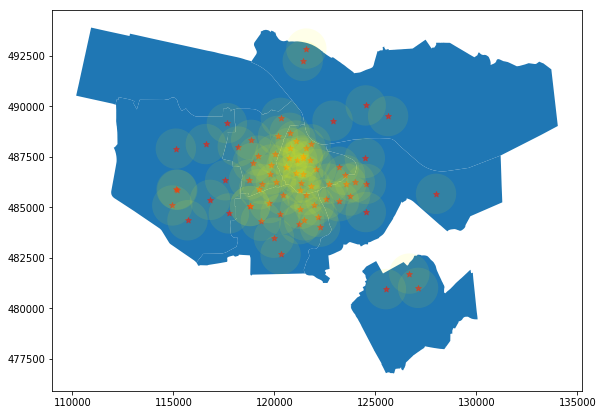

In [21]:
ah = get.get_df2(path = yml['path']['data_path_poi2'], file=yml['file']['ah'])
#oba = oba.reset_index(drop=True)
buffer=1000

In [5]:
keep_cols = [ 'id','geometry', 'sd_name', 'buffer']
poi2 = ah[keep_cols]

### load poi2 afvalcontainers

In [8]:
# load full afvalcontainers set first
afval_full = get.get_afvalcontainers_full_df(column_subset=True)

Fri, 21 Sep 2018 16:14:07 INFO     index has been reset
Fri, 21 Sep 2018 16:14:07 INFO     Afvalcontainers_full df has shape: (12298, 5) and crs: {'init': 'epsg:28992'}


In [9]:
print ('Choice your fractie')
fractie_choice

Choice your fractie


Dropdown(options=('Rest', 'Papier', 'Glas', 'Plastic', 'Textiel'), value=None)

In [10]:
fractie = fractie_choice.value 
buffer = yml['normen'][fractie]['kritiek_start']
bovengrens = yml['normen'][fractie]['bovengrens'] # value not according to distance norm

print ('fractie: {}'.format(fractie))
print ('buffer: {}'.format(buffer))
print ('bovengrens: {}'.format(bovengrens))

fractie: Rest
buffer: 200
bovengrens: 201


In [11]:
poi2 = get.dbscan_reduce_afvalcontainers(afval_full, fractie=fractie)

shape input frame afval_full : (12298, 5)
shape cluster_labels array: (12298,)
num_clusters: 5593
Clustered 12,298 afvalcontainers down to 4,858 inzamellocaties, for 60.50% compression in 1.22 sec.


### create_distance_matrix_general

In [23]:
stag_distance = dm.create_distance_matrix_general(df1=poi1, df2=poi2, buffer=buffer, 
                                               include_nearest_point=False,n=len(poi2))

Sun, 23 Sep 2018 20:00:19 INFO     Building dm (buffer: 1000 with 75 iterations


HBox(children=(IntProgress(value=0, max=75), HTML(value='')))

Shape sub_df 0 = (30466, 19)
Shape sub_df 1 = (32969, 19)
Shape sub_df 2 = (31724, 19)
Shape sub_df 3 = (30146, 19)
Shape sub_df 4 = (35636, 19)
Shape sub_df 5 = (17499, 19)
Shape sub_df 6 = (35398, 19)
Shape sub_df 7 = (28716, 19)
Shape sub_df 8 = (12957, 19)
Shape sub_df 9 = (22519, 19)
Shape sub_df 10 = (27603, 19)
Shape sub_df 11 = (26752, 19)
Shape sub_df 12 = (31826, 19)
Shape sub_df 13 = (9330, 19)
Shape sub_df 14 = (14047, 19)
Shape sub_df 15 = (12666, 19)
Shape sub_df 16 = (11995, 19)
Shape sub_df 17 = (14882, 19)
Shape sub_df 18 = (7393, 19)
Shape sub_df 19 = (13760, 19)
Shape sub_df 20 = (11390, 19)
Shape sub_df 21 = (13442, 19)
Shape sub_df 22 = (3714, 19)
Shape sub_df 23 = (10782, 19)
Shape sub_df 24 = (10286, 19)
Shape sub_df 25 = (10919, 19)
Shape sub_df 26 = (22431, 19)
Shape sub_df 27 = (17505, 19)
Shape sub_df 28 = (23012, 19)
Shape sub_df 29 = (27287, 19)
Shape sub_df 30 = (19975, 19)
Shape sub_df 31 = (23079, 19)
Shape sub_df 32 = (21755, 19)
Shape sub_df 33 = (2320

### deduplicate_distance_matrix_general

Sun, 23 Sep 2018 20:39:34 INFO     Raw dm has shape:(1527037, 19)
Sun, 23 Sep 2018 20:39:37 INFO     Aggregated dm has shape:(440646, 8)
Sun, 23 Sep 2018 20:39:37 INFO     merge results:
both          391196
left_only      49450
right_only         0
Name: _merge, dtype: int64
Sun, 23 Sep 2018 20:39:38 INFO     Filled values above the 1000 buffer boundaries with value: 1001
Sun, 23 Sep 2018 20:39:39 INFO     Final dm has shape:(440646, 9)
Sun, 23 Sep 2018 20:39:39 INFO     columns dm ['landelijk_pnd_id', 'geometry', 'geom_point', 'cluster_toewijzing', 'distance_min', 'distance_max', 'distance_mean', '_merge', 'pnd_dist_mean']


histogram numerical distance columns: 


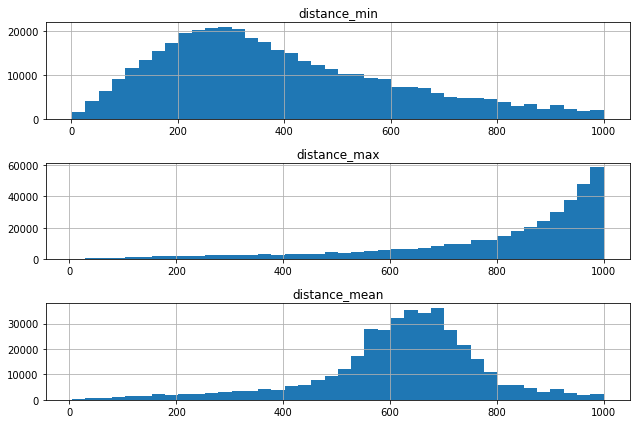

In [24]:
final = dm.deduplicate_distance_matrix_general(stag_distance, df1=poi1, buffer=buffer)

### create_distance_matrix_afval

In [12]:
stag_distance = dm.create_distance_matrix_afval(df1=poi1, df2=poi2, 
                                                fractie=fractie, 
                                                buffer = buffer, 
                                                include_nearest_point=False, 
                                                n=len(poi2))

Fri, 21 Sep 2018 16:14:43 INFO     Building dm (fractie: Rest, buffer: 200 with 4858 iterations


HBox(children=(IntProgress(value=0, max=4858), HTML(value='')))

Shape sub_df 0 = (36, 9)
Shape sub_df 1 = (124, 9)
Shape sub_df 2 = (0, 8)
Shape sub_df 3 = (370, 9)
Shape sub_df 4 = (221, 9)
Shape sub_df 5 = (201, 9)
Shape sub_df 6 = (311, 9)
Shape sub_df 7 = (188, 9)
Shape sub_df 8 = (519, 9)
Shape sub_df 9 = (205, 9)
Shape sub_df 10 = (245, 9)
Shape sub_df 11 = (308, 9)
Shape sub_df 12 = (158, 9)
Shape sub_df 13 = (90, 9)
Shape sub_df 14 = (131, 9)
Shape sub_df 15 = (78, 9)
Shape sub_df 16 = (204, 9)
Shape sub_df 17 = (321, 9)
Shape sub_df 18 = (162, 9)
Shape sub_df 19 = (440, 9)
Shape sub_df 20 = (163, 9)
Shape sub_df 21 = (52, 9)
Shape sub_df 22 = (118, 9)
Shape sub_df 23 = (267, 9)
Shape sub_df 24 = (95, 9)
Shape sub_df 25 = (371, 9)
Shape sub_df 26 = (134, 9)
Shape sub_df 27 = (173, 9)
Shape sub_df 28 = (273, 9)
Shape sub_df 29 = (251, 9)
Shape sub_df 30 = (153, 9)
Shape sub_df 31 = (346, 9)
Shape sub_df 32 = (280, 9)
Shape sub_df 33 = (205, 9)
Shape sub_df 34 = (157, 9)
Shape sub_df 35 = (211, 9)
Shape sub_df 36 = (143, 9)
Shape sub_df 37 = 

Shape sub_df 299 = (164, 9)
Shape sub_df 300 = (189, 9)
Shape sub_df 301 = (329, 9)
Shape sub_df 302 = (67, 9)
Shape sub_df 303 = (172, 9)
Shape sub_df 304 = (34, 9)
Shape sub_df 305 = (241, 9)
Shape sub_df 306 = (251, 9)
Shape sub_df 307 = (389, 9)
Shape sub_df 308 = (251, 9)
Shape sub_df 309 = (297, 9)
Shape sub_df 310 = (162, 9)
Shape sub_df 311 = (442, 9)
Shape sub_df 312 = (80, 9)
Shape sub_df 313 = (150, 9)
Shape sub_df 314 = (223, 9)
Shape sub_df 315 = (318, 9)
Shape sub_df 316 = (255, 9)
Shape sub_df 317 = (222, 9)
Shape sub_df 318 = (262, 9)
Shape sub_df 319 = (167, 9)
Shape sub_df 320 = (148, 9)
Shape sub_df 321 = (410, 9)
Shape sub_df 322 = (288, 9)
Shape sub_df 323 = (159, 9)
Shape sub_df 324 = (79, 9)
Shape sub_df 325 = (438, 9)
Shape sub_df 326 = (115, 9)
Shape sub_df 327 = (131, 9)
Shape sub_df 328 = (292, 9)
Shape sub_df 329 = (248, 9)
Shape sub_df 330 = (113, 9)
Shape sub_df 331 = (145, 9)
Shape sub_df 332 = (90, 9)
Shape sub_df 333 = (191, 9)
Shape sub_df 334 = (244, 

Shape sub_df 594 = (274, 9)
Shape sub_df 595 = (347, 9)
Shape sub_df 596 = (307, 9)
Shape sub_df 597 = (291, 9)
Shape sub_df 598 = (270, 9)
Shape sub_df 599 = (196, 9)
Shape sub_df 600 = (166, 9)
Shape sub_df 601 = (168, 9)
Shape sub_df 602 = (158, 9)
Shape sub_df 603 = (223, 9)
Shape sub_df 604 = (256, 9)
Shape sub_df 605 = (117, 9)
Shape sub_df 606 = (162, 9)
Shape sub_df 607 = (204, 9)
Shape sub_df 608 = (264, 9)
Shape sub_df 609 = (112, 9)
Shape sub_df 610 = (210, 9)
Shape sub_df 611 = (119, 9)
Shape sub_df 612 = (328, 9)
Shape sub_df 613 = (133, 9)
Shape sub_df 614 = (250, 9)
Shape sub_df 615 = (391, 9)
Shape sub_df 616 = (297, 9)
Shape sub_df 617 = (174, 9)
Shape sub_df 618 = (120, 9)
Shape sub_df 619 = (285, 9)
Shape sub_df 620 = (411, 9)
Shape sub_df 621 = (65, 9)
Shape sub_df 622 = (332, 9)
Shape sub_df 623 = (97, 9)
Shape sub_df 624 = (282, 9)
Shape sub_df 625 = (154, 9)
Shape sub_df 626 = (165, 9)
Shape sub_df 627 = (124, 9)
Shape sub_df 628 = (187, 9)
Shape sub_df 629 = (19

Shape sub_df 889 = (89, 9)
Shape sub_df 890 = (286, 9)
Shape sub_df 891 = (74, 9)
Shape sub_df 892 = (336, 9)
Shape sub_df 893 = (296, 9)
Shape sub_df 894 = (171, 9)
Shape sub_df 895 = (257, 9)
Shape sub_df 896 = (317, 9)
Shape sub_df 897 = (121, 9)
Shape sub_df 898 = (101, 9)
Shape sub_df 899 = (152, 9)
Shape sub_df 900 = (136, 9)
Shape sub_df 901 = (267, 9)
Shape sub_df 902 = (31, 9)
Shape sub_df 903 = (132, 9)
Shape sub_df 904 = (378, 9)
Shape sub_df 905 = (167, 9)
Shape sub_df 906 = (137, 9)
Shape sub_df 907 = (287, 9)
Shape sub_df 908 = (186, 9)
Shape sub_df 909 = (67, 9)
Shape sub_df 910 = (207, 9)
Shape sub_df 911 = (253, 9)
Shape sub_df 912 = (197, 9)
Shape sub_df 913 = (181, 9)
Shape sub_df 914 = (108, 9)
Shape sub_df 915 = (70, 9)
Shape sub_df 916 = (82, 9)
Shape sub_df 917 = (60, 9)
Shape sub_df 918 = (221, 9)
Shape sub_df 919 = (223, 9)
Shape sub_df 920 = (51, 9)
Shape sub_df 921 = (48, 9)
Shape sub_df 922 = (184, 9)
Shape sub_df 923 = (255, 9)
Shape sub_df 924 = (110, 9)
S

Shape sub_df 1178 = (42, 9)
Shape sub_df 1179 = (198, 9)
Shape sub_df 1180 = (214, 9)
Shape sub_df 1181 = (174, 9)
Shape sub_df 1182 = (305, 9)
Shape sub_df 1183 = (191, 9)
Shape sub_df 1184 = (204, 9)
Shape sub_df 1185 = (70, 9)
Shape sub_df 1186 = (151, 9)
Shape sub_df 1187 = (362, 9)
Shape sub_df 1188 = (1, 9)
Shape sub_df 1189 = (145, 9)
Shape sub_df 1190 = (112, 9)
Shape sub_df 1191 = (335, 9)
Shape sub_df 1192 = (82, 9)
Shape sub_df 1193 = (255, 9)
Shape sub_df 1194 = (4, 9)
Shape sub_df 1195 = (308, 9)
Shape sub_df 1196 = (124, 9)
Shape sub_df 1197 = (40, 9)
Shape sub_df 1198 = (33, 9)
Shape sub_df 1199 = (253, 9)
Shape sub_df 1200 = (224, 9)
Shape sub_df 1201 = (125, 9)
Shape sub_df 1202 = (73, 9)
Shape sub_df 1203 = (286, 9)
Shape sub_df 1204 = (200, 9)
Shape sub_df 1205 = (140, 9)
Shape sub_df 1206 = (111, 9)
Shape sub_df 1207 = (207, 9)
Shape sub_df 1208 = (32, 9)
Shape sub_df 1209 = (126, 9)
Shape sub_df 1210 = (221, 9)
Shape sub_df 1211 = (117, 9)
Shape sub_df 1212 = (114,

Shape sub_df 1463 = (196, 9)
Shape sub_df 1464 = (317, 9)
Shape sub_df 1465 = (140, 9)
Shape sub_df 1466 = (188, 9)
Shape sub_df 1467 = (240, 9)
Shape sub_df 1468 = (282, 9)
Shape sub_df 1469 = (35, 9)
Shape sub_df 1470 = (242, 9)
Shape sub_df 1471 = (75, 9)
Shape sub_df 1472 = (264, 9)
Shape sub_df 1473 = (53, 9)
Shape sub_df 1474 = (374, 9)
Shape sub_df 1475 = (224, 9)
Shape sub_df 1476 = (57, 9)
Shape sub_df 1477 = (209, 9)
Shape sub_df 1478 = (406, 9)
Shape sub_df 1479 = (287, 9)
Shape sub_df 1480 = (86, 9)
Shape sub_df 1481 = (336, 9)
Shape sub_df 1482 = (458, 9)
Shape sub_df 1483 = (401, 9)
Shape sub_df 1484 = (79, 9)
Shape sub_df 1485 = (240, 9)
Shape sub_df 1486 = (317, 9)
Shape sub_df 1487 = (31, 9)
Shape sub_df 1488 = (0, 8)
Shape sub_df 1489 = (158, 9)
Shape sub_df 1490 = (233, 9)
Shape sub_df 1491 = (231, 9)
Shape sub_df 1492 = (44, 9)
Shape sub_df 1493 = (400, 9)
Shape sub_df 1494 = (326, 9)
Shape sub_df 1495 = (404, 9)
Shape sub_df 1496 = (160, 9)
Shape sub_df 1497 = (106

Shape sub_df 1748 = (31, 9)
Shape sub_df 1749 = (174, 9)
Shape sub_df 1750 = (206, 9)
Shape sub_df 1751 = (236, 9)
Shape sub_df 1752 = (223, 9)
Shape sub_df 1753 = (245, 9)
Shape sub_df 1754 = (157, 9)
Shape sub_df 1755 = (125, 9)
Shape sub_df 1756 = (68, 9)
Shape sub_df 1757 = (269, 9)
Shape sub_df 1758 = (295, 9)
Shape sub_df 1759 = (252, 9)
Shape sub_df 1760 = (205, 9)
Shape sub_df 1761 = (117, 9)
Shape sub_df 1762 = (193, 9)
Shape sub_df 1763 = (251, 9)
Shape sub_df 1764 = (77, 9)
Shape sub_df 1765 = (19, 9)
Shape sub_df 1766 = (283, 9)
Shape sub_df 1767 = (27, 9)
Shape sub_df 1768 = (257, 9)
Shape sub_df 1769 = (241, 9)
Shape sub_df 1770 = (358, 9)
Shape sub_df 1771 = (254, 9)
Shape sub_df 1772 = (160, 9)
Shape sub_df 1773 = (321, 9)
Shape sub_df 1774 = (149, 9)
Shape sub_df 1775 = (303, 9)
Shape sub_df 1776 = (448, 9)
Shape sub_df 1777 = (230, 9)
Shape sub_df 1778 = (154, 9)
Shape sub_df 1779 = (258, 9)
Shape sub_df 1780 = (116, 9)
Shape sub_df 1781 = (230, 9)
Shape sub_df 1782 =

Shape sub_df 2032 = (317, 9)
Shape sub_df 2033 = (207, 9)
Shape sub_df 2034 = (135, 9)
Shape sub_df 2035 = (199, 9)
Shape sub_df 2036 = (352, 9)
Shape sub_df 2037 = (237, 9)
Shape sub_df 2038 = (142, 9)
Shape sub_df 2039 = (58, 9)
Shape sub_df 2040 = (81, 9)
Shape sub_df 2041 = (221, 9)
Shape sub_df 2042 = (143, 9)
Shape sub_df 2043 = (324, 9)
Shape sub_df 2044 = (115, 9)
Shape sub_df 2045 = (174, 9)
Shape sub_df 2046 = (500, 9)
Shape sub_df 2047 = (243, 9)
Shape sub_df 2048 = (307, 9)
Shape sub_df 2049 = (219, 9)
Shape sub_df 2050 = (29, 9)
Shape sub_df 2051 = (129, 9)
Shape sub_df 2052 = (247, 9)
Shape sub_df 2053 = (129, 9)
Shape sub_df 2054 = (215, 9)
Shape sub_df 2055 = (247, 9)
Shape sub_df 2056 = (60, 9)
Shape sub_df 2057 = (231, 9)
Shape sub_df 2058 = (19, 9)
Shape sub_df 2059 = (375, 9)
Shape sub_df 2060 = (213, 9)
Shape sub_df 2061 = (199, 9)
Shape sub_df 2062 = (306, 9)
Shape sub_df 2063 = (251, 9)
Shape sub_df 2064 = (118, 9)
Shape sub_df 2065 = (225, 9)
Shape sub_df 2066 =

Shape sub_df 2317 = (254, 9)
Shape sub_df 2318 = (95, 9)
Shape sub_df 2319 = (0, 8)
Shape sub_df 2320 = (43, 9)
Shape sub_df 2321 = (123, 9)
Shape sub_df 2322 = (205, 9)
Shape sub_df 2323 = (133, 9)
Shape sub_df 2324 = (155, 9)
Shape sub_df 2325 = (555, 9)
Shape sub_df 2326 = (199, 9)
Shape sub_df 2327 = (317, 9)
Shape sub_df 2328 = (358, 9)
Shape sub_df 2329 = (282, 9)
Shape sub_df 2330 = (10, 9)
Shape sub_df 2331 = (66, 9)
Shape sub_df 2332 = (130, 9)
Shape sub_df 2333 = (343, 9)
Shape sub_df 2334 = (160, 9)
Shape sub_df 2335 = (164, 9)
Shape sub_df 2336 = (13, 9)
Shape sub_df 2337 = (147, 9)
Shape sub_df 2338 = (459, 9)
Shape sub_df 2339 = (217, 9)
Shape sub_df 2340 = (385, 9)
Shape sub_df 2341 = (154, 9)
Shape sub_df 2342 = (132, 9)
Shape sub_df 2343 = (304, 9)
Shape sub_df 2344 = (282, 9)
Shape sub_df 2345 = (157, 9)
Shape sub_df 2346 = (94, 9)
Shape sub_df 2347 = (519, 9)
Shape sub_df 2348 = (464, 9)
Shape sub_df 2349 = (193, 9)
Shape sub_df 2350 = (229, 9)
Shape sub_df 2351 = (9

Shape sub_df 2602 = (179, 9)
Shape sub_df 2603 = (392, 9)
Shape sub_df 2604 = (469, 9)
Shape sub_df 2605 = (392, 9)
Shape sub_df 2606 = (115, 9)
Shape sub_df 2607 = (209, 9)
Shape sub_df 2608 = (194, 9)
Shape sub_df 2609 = (330, 9)
Shape sub_df 2610 = (333, 9)
Shape sub_df 2611 = (141, 9)
Shape sub_df 2612 = (143, 9)
Shape sub_df 2613 = (217, 9)
Shape sub_df 2614 = (131, 9)
Shape sub_df 2615 = (63, 9)
Shape sub_df 2616 = (232, 9)
Shape sub_df 2617 = (464, 9)
Shape sub_df 2618 = (249, 9)
Shape sub_df 2619 = (305, 9)
Shape sub_df 2620 = (108, 9)
Shape sub_df 2621 = (395, 9)
Shape sub_df 2622 = (138, 9)
Shape sub_df 2623 = (338, 9)
Shape sub_df 2624 = (121, 9)
Shape sub_df 2625 = (132, 9)
Shape sub_df 2626 = (278, 9)
Shape sub_df 2627 = (239, 9)
Shape sub_df 2628 = (538, 9)
Shape sub_df 2629 = (68, 9)
Shape sub_df 2630 = (249, 9)
Shape sub_df 2631 = (413, 9)
Shape sub_df 2632 = (148, 9)
Shape sub_df 2633 = (73, 9)
Shape sub_df 2634 = (290, 9)
Shape sub_df 2635 = (97, 9)
Shape sub_df 2636 

Shape sub_df 2887 = (275, 9)
Shape sub_df 2888 = (204, 9)
Shape sub_df 2889 = (367, 9)
Shape sub_df 2890 = (110, 9)
Shape sub_df 2891 = (48, 9)
Shape sub_df 2892 = (251, 9)
Shape sub_df 2893 = (270, 9)
Shape sub_df 2894 = (181, 9)
Shape sub_df 2895 = (198, 9)
Shape sub_df 2896 = (57, 9)
Shape sub_df 2897 = (240, 9)
Shape sub_df 2898 = (31, 9)
Shape sub_df 2899 = (335, 9)
Shape sub_df 2900 = (203, 9)
Shape sub_df 2901 = (265, 9)
Shape sub_df 2902 = (252, 9)
Shape sub_df 2903 = (280, 9)
Shape sub_df 2904 = (297, 9)
Shape sub_df 2905 = (145, 9)
Shape sub_df 2906 = (232, 9)
Shape sub_df 2907 = (354, 9)
Shape sub_df 2908 = (158, 9)
Shape sub_df 2909 = (338, 9)
Shape sub_df 2910 = (159, 9)
Shape sub_df 2911 = (199, 9)
Shape sub_df 2912 = (192, 9)
Shape sub_df 2913 = (84, 9)
Shape sub_df 2914 = (165, 9)
Shape sub_df 2915 = (202, 9)
Shape sub_df 2916 = (189, 9)
Shape sub_df 2917 = (82, 9)
Shape sub_df 2918 = (281, 9)
Shape sub_df 2919 = (260, 9)
Shape sub_df 2920 = (375, 9)
Shape sub_df 2921 =

Shape sub_df 3172 = (323, 9)
Shape sub_df 3173 = (172, 9)
Shape sub_df 3174 = (372, 9)
Shape sub_df 3175 = (153, 9)
Shape sub_df 3176 = (138, 9)
Shape sub_df 3177 = (14, 9)
Shape sub_df 3178 = (229, 9)
Shape sub_df 3179 = (147, 9)
Shape sub_df 3180 = (359, 9)
Shape sub_df 3181 = (63, 9)
Shape sub_df 3182 = (121, 9)
Shape sub_df 3183 = (293, 9)
Shape sub_df 3184 = (157, 9)
Shape sub_df 3185 = (186, 9)
Shape sub_df 3186 = (494, 9)
Shape sub_df 3187 = (347, 9)
Shape sub_df 3188 = (183, 9)
Shape sub_df 3189 = (115, 9)
Shape sub_df 3190 = (177, 9)
Shape sub_df 3191 = (156, 9)
Shape sub_df 3192 = (323, 9)
Shape sub_df 3193 = (145, 9)
Shape sub_df 3194 = (255, 9)
Shape sub_df 3195 = (49, 9)
Shape sub_df 3196 = (337, 9)
Shape sub_df 3197 = (235, 9)
Shape sub_df 3198 = (215, 9)
Shape sub_df 3199 = (87, 9)
Shape sub_df 3200 = (175, 9)
Shape sub_df 3201 = (208, 9)
Shape sub_df 3202 = (165, 9)
Shape sub_df 3203 = (309, 9)
Shape sub_df 3204 = (420, 9)
Shape sub_df 3205 = (262, 9)
Shape sub_df 3206 

Shape sub_df 3456 = (132, 9)
Shape sub_df 3457 = (379, 9)
Shape sub_df 3458 = (214, 9)
Shape sub_df 3459 = (279, 9)
Shape sub_df 3460 = (244, 9)
Shape sub_df 3461 = (51, 9)
Shape sub_df 3462 = (439, 9)
Shape sub_df 3463 = (206, 9)
Shape sub_df 3464 = (375, 9)
Shape sub_df 3465 = (398, 9)
Shape sub_df 3466 = (70, 9)
Shape sub_df 3467 = (284, 9)
Shape sub_df 3468 = (250, 9)
Shape sub_df 3469 = (134, 9)
Shape sub_df 3470 = (134, 9)
Shape sub_df 3471 = (256, 9)
Shape sub_df 3472 = (211, 9)
Shape sub_df 3473 = (295, 9)
Shape sub_df 3474 = (146, 9)
Shape sub_df 3475 = (200, 9)
Shape sub_df 3476 = (377, 9)
Shape sub_df 3477 = (74, 9)
Shape sub_df 3478 = (298, 9)
Shape sub_df 3479 = (318, 9)
Shape sub_df 3480 = (64, 9)
Shape sub_df 3481 = (61, 9)
Shape sub_df 3482 = (183, 9)
Shape sub_df 3483 = (134, 9)
Shape sub_df 3484 = (165, 9)
Shape sub_df 3485 = (342, 9)
Shape sub_df 3486 = (75, 9)
Shape sub_df 3487 = (335, 9)
Shape sub_df 3488 = (71, 9)
Shape sub_df 3489 = (189, 9)
Shape sub_df 3490 = (

Shape sub_df 3741 = (75, 9)
Shape sub_df 3742 = (228, 9)
Shape sub_df 3743 = (51, 9)
Shape sub_df 3744 = (148, 9)
Shape sub_df 3745 = (49, 9)
Shape sub_df 3746 = (270, 9)
Shape sub_df 3747 = (243, 9)
Shape sub_df 3748 = (55, 9)
Shape sub_df 3749 = (393, 9)
Shape sub_df 3750 = (261, 9)
Shape sub_df 3751 = (79, 9)
Shape sub_df 3752 = (164, 9)
Shape sub_df 3753 = (353, 9)
Shape sub_df 3754 = (79, 9)
Shape sub_df 3755 = (280, 9)
Shape sub_df 3756 = (124, 9)
Shape sub_df 3757 = (442, 9)
Shape sub_df 3758 = (364, 9)
Shape sub_df 3759 = (164, 9)
Shape sub_df 3760 = (116, 9)
Shape sub_df 3761 = (1, 9)
Shape sub_df 3762 = (174, 9)
Shape sub_df 3763 = (257, 9)
Shape sub_df 3764 = (213, 9)
Shape sub_df 3765 = (337, 9)
Shape sub_df 3766 = (355, 9)
Shape sub_df 3767 = (237, 9)
Shape sub_df 3768 = (229, 9)
Shape sub_df 3769 = (321, 9)
Shape sub_df 3770 = (229, 9)
Shape sub_df 3771 = (412, 9)
Shape sub_df 3772 = (197, 9)
Shape sub_df 3773 = (210, 9)
Shape sub_df 3774 = (98, 9)
Shape sub_df 3775 = (11

Shape sub_df 4026 = (168, 9)
Shape sub_df 4027 = (129, 9)
Shape sub_df 4028 = (129, 9)
Shape sub_df 4029 = (307, 9)
Shape sub_df 4030 = (292, 9)
Shape sub_df 4031 = (340, 9)
Shape sub_df 4032 = (133, 9)
Shape sub_df 4033 = (87, 9)
Shape sub_df 4034 = (242, 9)
Shape sub_df 4035 = (278, 9)
Shape sub_df 4036 = (193, 9)
Shape sub_df 4037 = (306, 9)
Shape sub_df 4038 = (22, 9)
Shape sub_df 4039 = (127, 9)
Shape sub_df 4040 = (78, 9)
Shape sub_df 4041 = (277, 9)
Shape sub_df 4042 = (136, 9)
Shape sub_df 4043 = (132, 9)
Shape sub_df 4044 = (210, 9)
Shape sub_df 4045 = (170, 9)
Shape sub_df 4046 = (126, 9)
Shape sub_df 4047 = (105, 9)
Shape sub_df 4048 = (190, 9)
Shape sub_df 4049 = (290, 9)
Shape sub_df 4050 = (156, 9)
Shape sub_df 4051 = (246, 9)
Shape sub_df 4052 = (129, 9)
Shape sub_df 4053 = (131, 9)
Shape sub_df 4054 = (89, 9)
Shape sub_df 4055 = (62, 9)
Shape sub_df 4056 = (187, 9)
Shape sub_df 4057 = (264, 9)
Shape sub_df 4058 = (136, 9)
Shape sub_df 4059 = (77, 9)
Shape sub_df 4060 = 

Shape sub_df 4311 = (222, 9)
Shape sub_df 4312 = (170, 9)
Shape sub_df 4313 = (224, 9)
Shape sub_df 4314 = (427, 9)
Shape sub_df 4315 = (159, 9)
Shape sub_df 4316 = (259, 9)
Shape sub_df 4317 = (95, 9)
Shape sub_df 4318 = (278, 9)
Shape sub_df 4319 = (232, 9)
Shape sub_df 4320 = (271, 9)
Shape sub_df 4321 = (88, 9)
Shape sub_df 4322 = (0, 8)
Shape sub_df 4323 = (246, 9)
Shape sub_df 4324 = (87, 9)
Shape sub_df 4325 = (102, 9)
Shape sub_df 4326 = (141, 9)
Shape sub_df 4327 = (200, 9)
Shape sub_df 4328 = (184, 9)
Shape sub_df 4329 = (185, 9)
Shape sub_df 4330 = (30, 9)
Shape sub_df 4331 = (183, 9)
Shape sub_df 4332 = (80, 9)
Shape sub_df 4333 = (124, 9)
Shape sub_df 4334 = (267, 9)
Shape sub_df 4335 = (386, 9)
Shape sub_df 4336 = (63, 9)
Shape sub_df 4337 = (127, 9)
Shape sub_df 4338 = (85, 9)
Shape sub_df 4339 = (278, 9)
Shape sub_df 4340 = (197, 9)
Shape sub_df 4341 = (276, 9)
Shape sub_df 4342 = (88, 9)
Shape sub_df 4343 = (178, 9)
Shape sub_df 4344 = (235, 9)
Shape sub_df 4345 = (246

Shape sub_df 4596 = (2, 9)
Shape sub_df 4597 = (70, 9)
Shape sub_df 4598 = (234, 9)
Shape sub_df 4599 = (306, 9)
Shape sub_df 4600 = (75, 9)
Shape sub_df 4601 = (260, 9)
Shape sub_df 4602 = (248, 9)
Shape sub_df 4603 = (124, 9)
Shape sub_df 4604 = (209, 9)
Shape sub_df 4605 = (243, 9)
Shape sub_df 4606 = (146, 9)
Shape sub_df 4607 = (113, 9)
Shape sub_df 4608 = (82, 9)
Shape sub_df 4609 = (112, 9)
Shape sub_df 4610 = (157, 9)
Shape sub_df 4611 = (186, 9)
Shape sub_df 4612 = (259, 9)
Shape sub_df 4613 = (58, 9)
Shape sub_df 4614 = (353, 9)
Shape sub_df 4615 = (122, 9)
Shape sub_df 4616 = (271, 9)
Shape sub_df 4617 = (169, 9)
Shape sub_df 4618 = (259, 9)
Shape sub_df 4619 = (72, 9)
Shape sub_df 4620 = (265, 9)
Shape sub_df 4621 = (310, 9)
Shape sub_df 4622 = (205, 9)
Shape sub_df 4623 = (203, 9)
Shape sub_df 4624 = (96, 9)
Shape sub_df 4625 = (523, 9)
Shape sub_df 4626 = (70, 9)
Shape sub_df 4627 = (108, 9)
Shape sub_df 4628 = (191, 9)
Shape sub_df 4629 = (214, 9)
Shape sub_df 4630 = (18

Fri, 21 Sep 2018 17:18:38 INFO     Raw dm has shape:(987630, 9)
Fri, 21 Sep 2018 17:18:39 INFO     Aggregated dm has shape:(105943, 8)
Fri, 21 Sep 2018 17:18:39 INFO     merge results:
both          92277
left_only     13666
right_only        0
Name: _merge, dtype: int64
Fri, 21 Sep 2018 17:18:39 INFO     Filled values above the 200 norm with bovengrens value: 201
Fri, 21 Sep 2018 17:18:39 INFO     Final dm has shape:(105943, 9)
Fri, 21 Sep 2018 17:18:39 INFO     columns dm ['landelijk_pnd_id', 'geometry', 'geom_point', 'cluster_toewijzing', 'distance_min', 'distance_max', 'distance_mean', '_merge', 'pnd_dist_mean']


histogram numerical distance columns: 


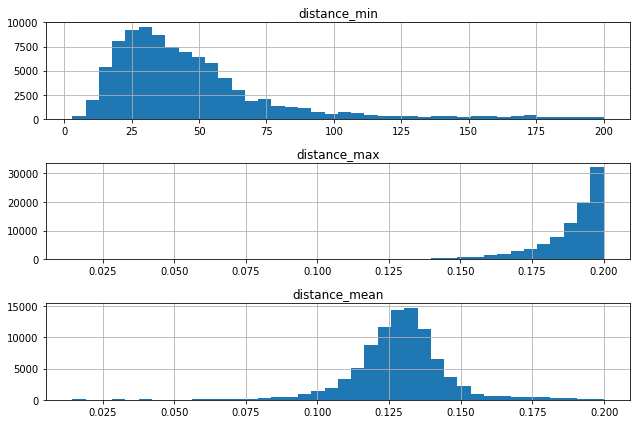

In [13]:
final = dm.deduplicate_distance_matrix_afval(stag_distance, 
                                             df1=poi1, 
                                             buffer = buffer,
                                             bovengrens=bovengrens)

### write to csv (for afvalcontainer sets)

In [58]:
final.to_csv(yml['path']['distance_matrices'] + 'distance_huur_' + fractie + '.csv', index=False)

### write to csv (for general sets)

In [25]:
final.to_csv(yml['path']['distance_matrices'] + 'distance_vot_all_ah.csv', index=False)